# Hotel Booking Demand - EDA

## Introduction

The goal of this EDA analysis is to understand booking patterns and identify key drivers of cancellations in hotel booking data. This will guide predictive modeling and support business insights.

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="Set2")

# Load dataset
df = pd.read_csv('../data/processed/hotel_booking_clean.csv')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (87370, 30)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Cancellation Overview

We compare **cancellations vs. check-outs** rates across the two hotels.

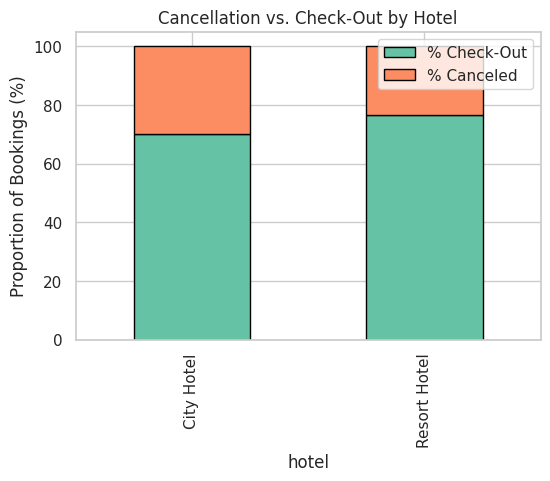

In [ ]:
# Cancellation summary by hotel
cancellation_summary = df.groupby("hotel").agg(
    Total_Bookings=("is_canceled", "count"),
    Check_Out=("is_canceled", lambda x: (x == 0).sum()),
    Canceled=("is_canceled", "sum")
)

# Convert to percentages
cancellation_summary["% Check-Out"] = cancellation_summary["Check_Out"] / cancellation_summary["Total_Bookings"] * 100
cancellation_summary["% Canceled"] = cancellation_summary["Canceled"] / cancellation_summary["Total_Bookings"] * 100

# Plot stacked % bars
cancellation_summary[["% Check-Out", "% Canceled"]].plot(
    kind="bar", stacked=True, figsize=(6,4), edgecolor="black"
)
plt.ylabel("Proportion of Bookings (%)")
plt.title("Cancellation vs. Check-Out by Hotel")
plt.show()

**Insights:**  
* **City Hotel** shows a higher cancellation rate (**~29%**) compared to **Resort Hotel** (**~23%**).  
* This suggests that city stays are more prone to cancellations, possibly linked to shorter, business-related trips or more flexible travel plans.  


## Guest Demographics & Groups
We profile where guests come from and their repeat behavior.

In [33]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

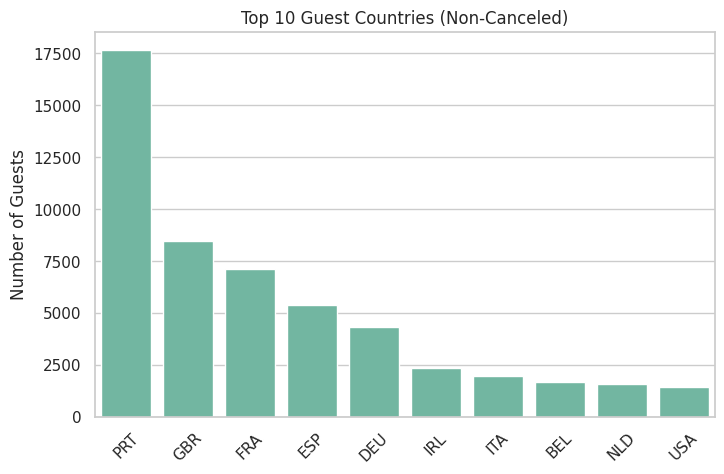

In [46]:
# Top 10 guest countries (non-canceled)
top10 = (
    df[df["is_canceled"]==0]["country"]
    .value_counts()
    .head(10)
    .reset_index()
)

top10.columns = ["Country","Guests"]

plt.figure(figsize=(8,5))
sns.barplot(data=top10, x="Country", y="Guests")
plt.title("Top 10 Guest Countries (Non-Canceled)")
plt.ylabel("Number of Guests")
plt.xlabel("")
plt.xticks(rotation=45)
plt.show()


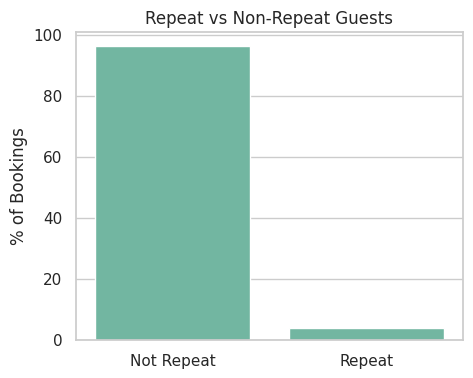

In [ ]:
# Repeat guests (% distribution)
repeat_guest_dist = (
    df["is_repeated_guest"]
    .map({0:"Not Repeat",1:"Repeat"})
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)

repeat_guest_dist.columns = ["Type","Percentage"]

plt.figure(figsize=(5,4))
sns.barplot(data=repeat_guest_dist, x="Type", y="Percentage")
plt.title("Repeat vs Non-Repeat Guests")
plt.ylabel("% of Bookings")
plt.xlabel("")
plt.show()


* Guest demand is led by Portugal, with the UK and Spain following behind.
* Repeat guests make up only a small share (~3%), highlighting weak retention. 

## Booking Characteristics

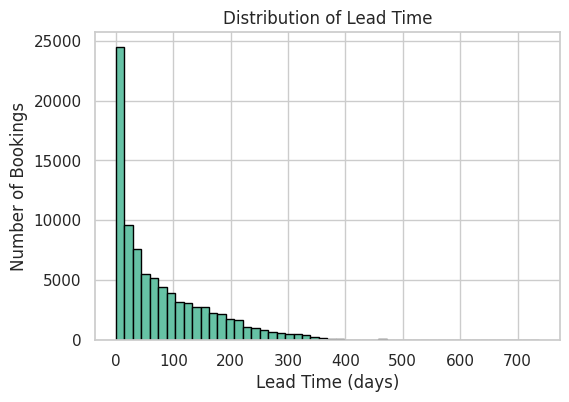

In [ ]:
# Lead time distribution
plt.figure(figsize=(6,4))
df["lead_time"].plot(kind="hist", bins=50, edgecolor="black")
plt.xlabel("Lead Time (days)")
plt.ylabel("Number of Bookings")
plt.title("Distribution of Lead Time")
plt.show()

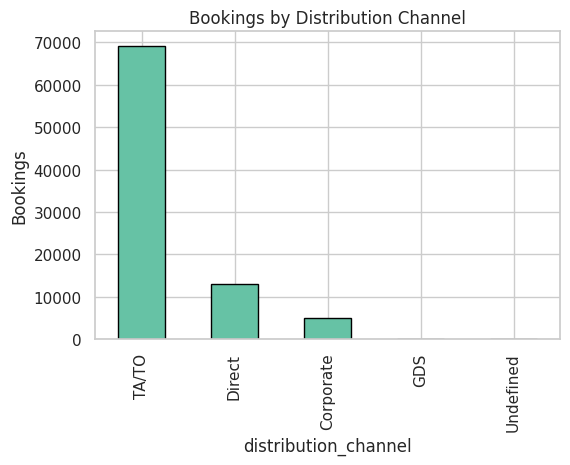

In [ ]:
plt.figure(figsize=(6,4))
df["distribution_channel"].value_counts().plot(kind="bar", edgecolor="black")
plt.ylabel("Bookings")
plt.title("Bookings by Distribution Channel")
plt.show()

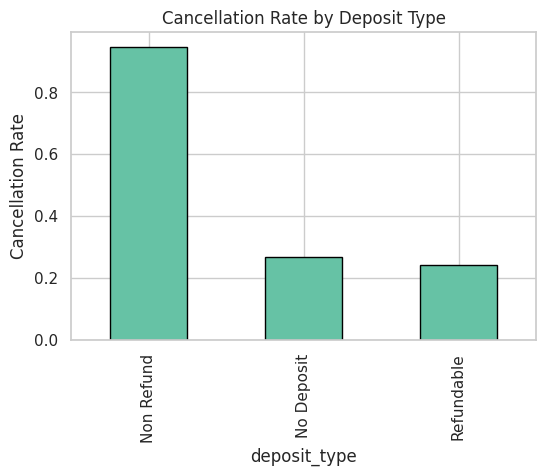

In [45]:
# Cancellation rate by deposit type
deposit_cancel_rate = df.groupby("deposit_type")["is_canceled"].mean().sort_values(ascending=False)
deposit_cancel_rate.plot(kind="bar", edgecolor="black", figsize=(6,4))
plt.ylabel("Cancellation Rate")
plt.title("Cancellation Rate by Deposit Type")
plt.show()

**Insights:**  
* Median **lead time** is ~90 days, with a strongly right-skewed distribution.  
* Most bookings are made through **travel agents/tour operators**.  
* **Non-Refund** deposits have a cancellation rate of over **90%**, likely due to speculative bookings or incorrect payment details in OTA/TA channels.  

## Seasonality & Time Patterns

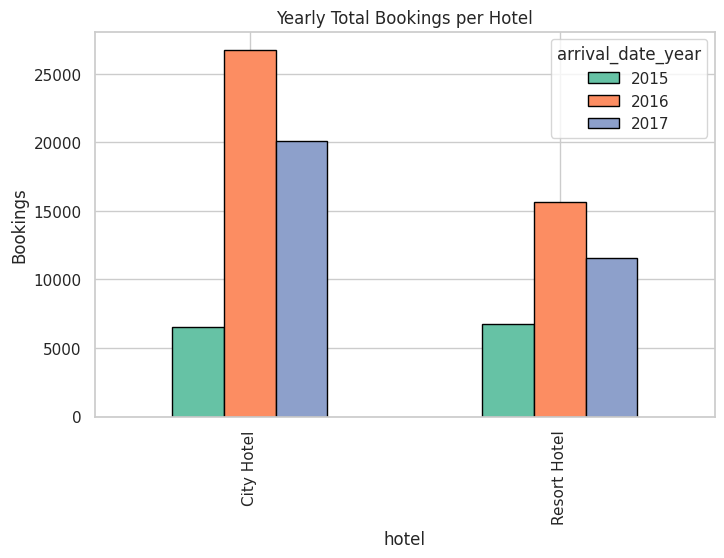

In [39]:
# Yearly bookings
yearly_bookings = df.groupby(["hotel","arrival_date_year"]).size().unstack()
yearly_bookings.plot(kind="bar", figsize=(8,5), edgecolor="black")
plt.title("Yearly Total Bookings per Hotel")
plt.ylabel("Bookings")
plt.show()

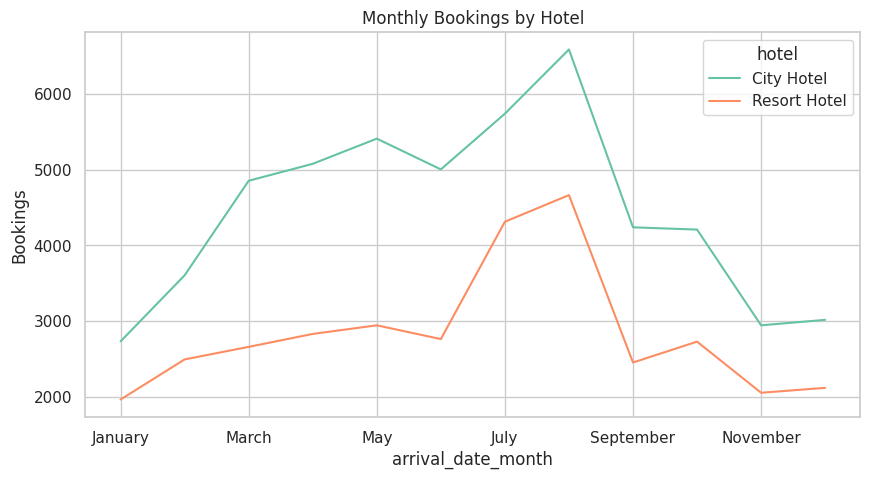

In [40]:
# Monthly bookings
monthly_order = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]
monthly_bookings = df.groupby(["hotel","arrival_date_month"]).size().unstack().reindex(columns=monthly_order)
monthly_bookings.T.plot(figsize=(10,5))
plt.title("Monthly Bookings by Hotel")
plt.ylabel("Bookings")
plt.show()

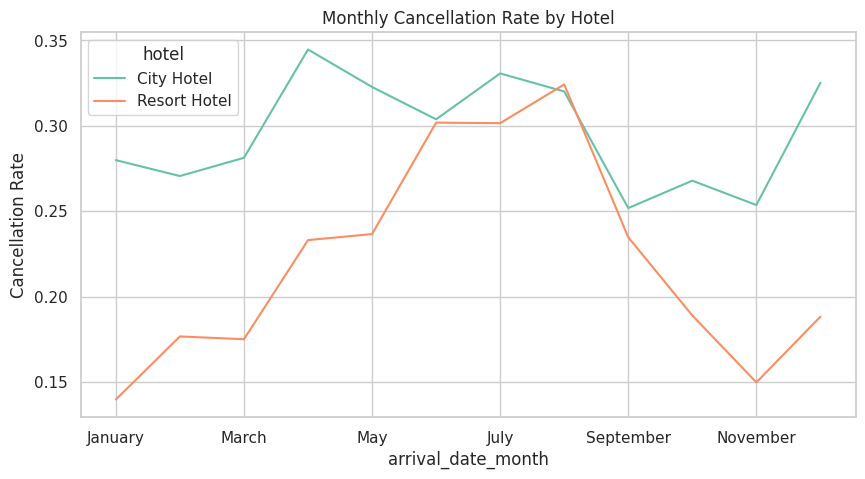

In [41]:
# Monthly cancellation rates
monthly_cancel_rate = (
    df.groupby(["hotel","arrival_date_month"])["is_canceled"].mean().unstack().reindex(columns=monthly_order)
)
monthly_cancel_rate.T.plot(figsize=(10,5))
plt.title("Monthly Cancellation Rate by Hotel")
plt.ylabel("Cancellation Rate")
plt.show()

**Insights:**  
* **City Hotel**: steady demand year-round.  
* **Resort Hotel**: strong summer peaks (July–August).  

## Financial & Revenue Insights  

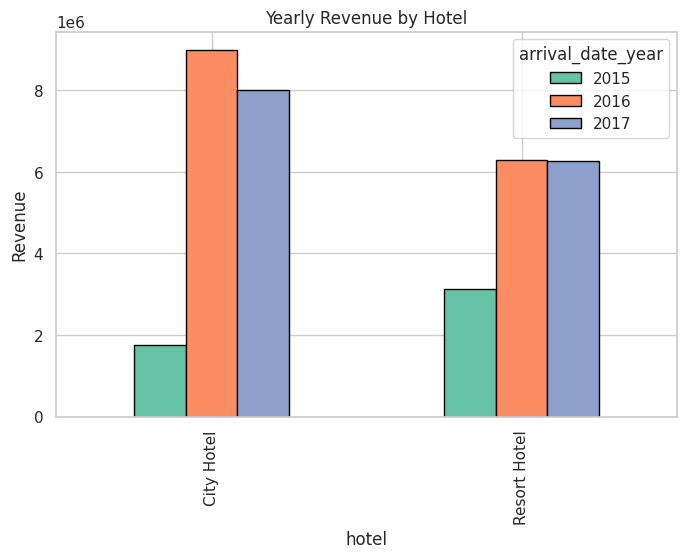

In [42]:
# Capacity estimation (max observed rooms occupied)
df["nights"] = df["stays_in_week_nights"] + df["stays_in_weekend_nights"]
capacity_est = df.groupby("hotel")[["adults","children","babies"]].sum().max(axis=1)

# Revenue per booking
df["room_revenue"] = df["adr"] * df["nights"]

# Yearly revenue
yearly_revenue = df.groupby(["hotel","arrival_date_year"])["room_revenue"].sum().unstack()
yearly_revenue.plot(kind="bar", figsize=(8,5), edgecolor="black")
plt.ylabel("Revenue")
plt.title("Yearly Revenue by Hotel")
plt.show()



 **Insights:**  
* **City Hotel** revenue peaked in 2016, dipped in 2017.
* **Resort Hotel**: Stronger growth, with sharp seasonal peaks in summer driving revenue. 

## Correlation Analysis

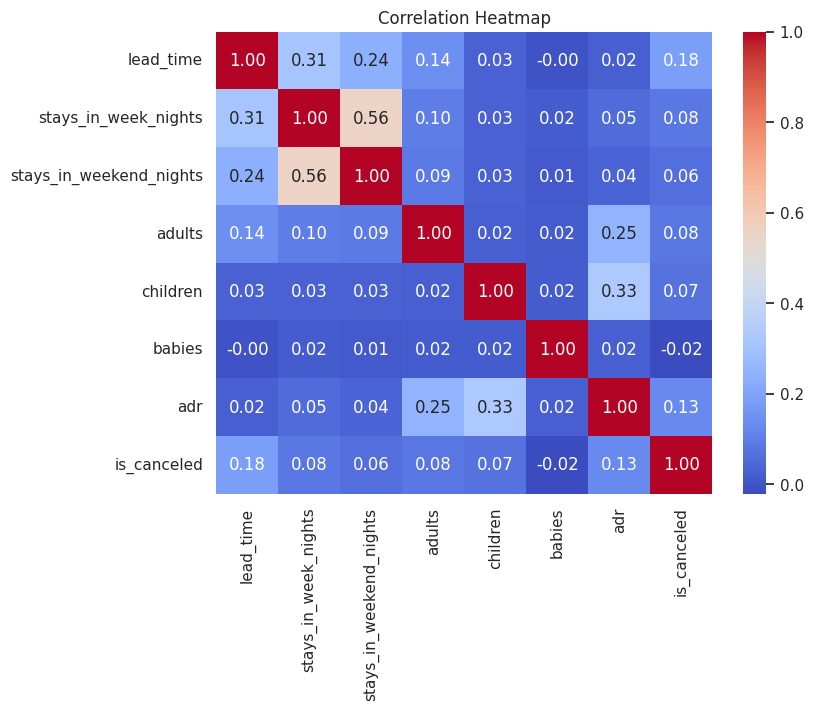

In [43]:
# Correlation heatmap
corr_cols = ["lead_time","stays_in_week_nights","stays_in_weekend_nights",
             "adults","children","babies","adr","is_canceled"]

plt.figure(figsize=(8,6))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


 **Insights:**  
* Longer lead times correlate with higher cancellations (corr ~0.19).  
* ADR (price) is moderately correlated with group size (children corr ~0.33, adults ~0.25).  


## Summary

This exploratory analysis reveals several patterns in hotel bookings:  

* **Demand**  
  - City Hotel: steady demand, higher volume.  
  - Resort Hotel: seasonal, strong summer peaks.  

* **Cancellations**  
  - City Hotel: ~29% vs Resort Hotel: ~23%.  
  - Strongly influenced by **deposit type** and **lead time**.  

* **Revenue**  
  - City Hotel: stable overall, resilient RevPAR despite 2017 dip.  
  - Resort Hotel: strong growth with seasonal peaks.  

* **Guest Profile**  
  - Portugal leads (~40%), UK and Spain follow.  
  - Repeat guests only ~3% of bookings.  

* **Modeling Implications**  
  - Likely strong features: **deposit_type, lead_time, seasonality, market_segment**.  
